In [1]:
renv::init('/oak/stanford/groups/agitler/Shared/Shared_Jupyter_Notebook_Analysis/4.1.1-OG/')

In [2]:
library(dplyr)
library(Seurat)
library(ggplot2)
library(ggrepel)
library(ComplexHeatmap)
library(gplots)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




## Save Directories for Figs + Tables

In [3]:
fig_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/Figure_Panels'
csv_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/CSV_Files'

## Load Yadav data

In [11]:
yadav <- readRDS('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/HumanSpinalCord_seurat_obj.rds')
DefaultAssay(yadav) <- "RNA"

In [12]:
# Normalize the data
yadav <- NormalizeData(yadav, normalization.method = "LogNormalize", scale.factor = 10000)

In [13]:
yadav_neurons <- subset(yadav, top_level_annotation == "Neurons")

In [14]:
yadav_neurons$motor_neuron <- ifelse(yadav_neurons$subtype_annotation == "Motoneurons", yes = "Motor Neurons", no = "Other Neurons")

In [15]:
yadav_mns <- subset(yadav_neurons, motor_neuron == "Motor Neurons")

## Violin plots - Yadav

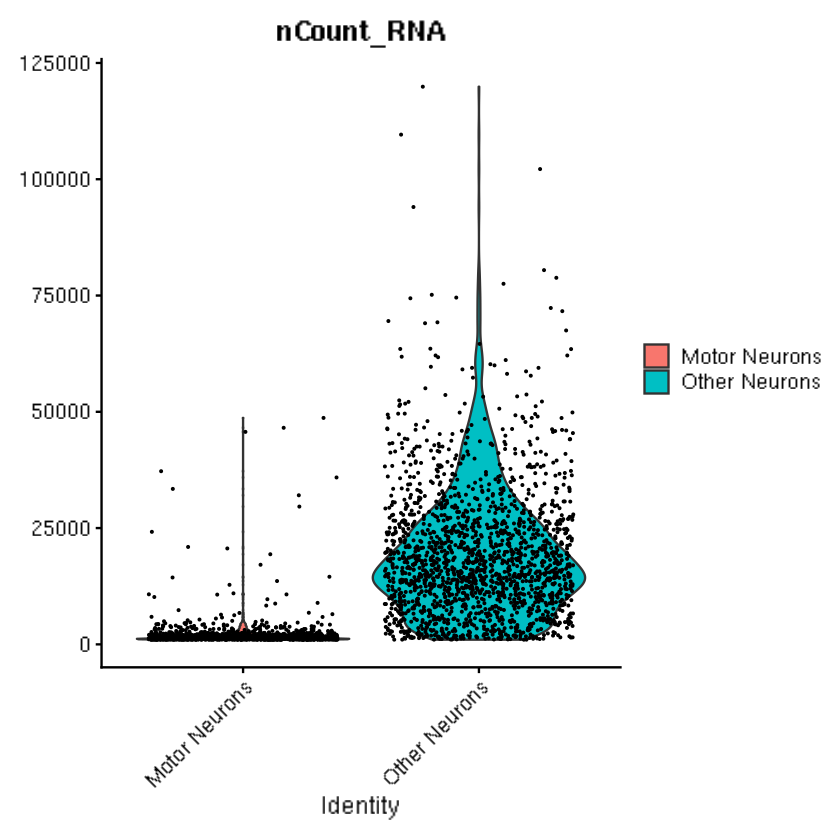

In [16]:
VlnPlot(yadav_neurons, group.by = "motor_neuron", features = "nCount_RNA")

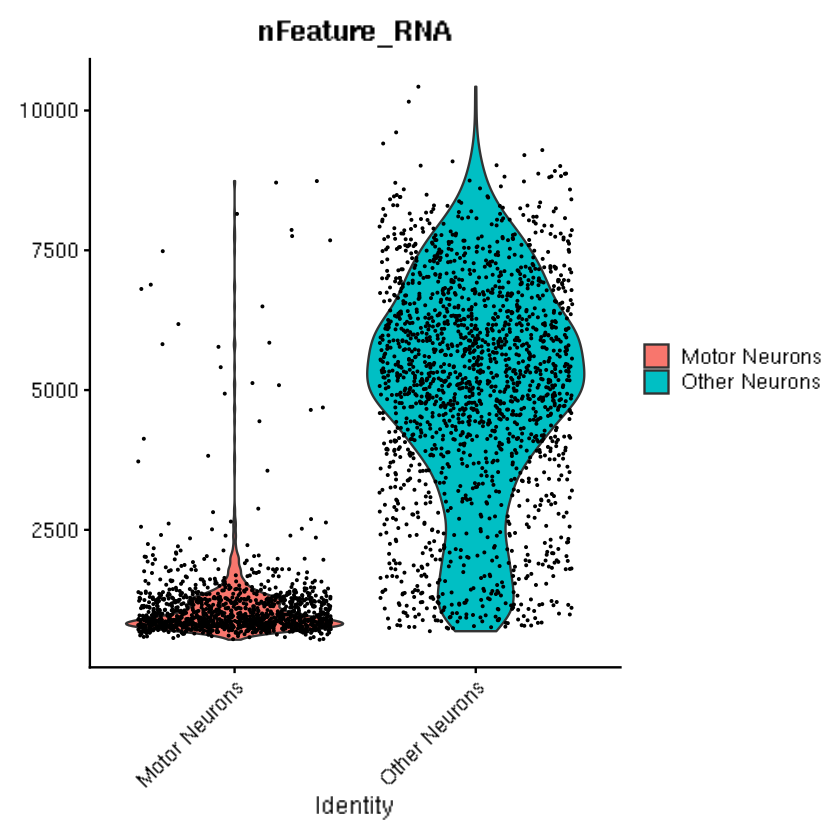

In [17]:
VlnPlot(yadav_neurons, group.by = "motor_neuron", features = "nFeature_RNA")

In [18]:
median_nCount <- filter(yadav_neurons@meta.data, motor_neuron == "Other Neurons") %>% {median(.$nCount_RNA)}

In [19]:
median_nCount

[1] 16809.5

In [20]:
filter(yadav_neurons@meta.data, motor_neuron == "Motoneurons") %>% {median(.$nCount_RNA)}

[1] NA

In [21]:
yadav_neurons$norm_nCount_RNA = yadav_neurons$nCount_RNA/median_nCount

In [22]:
median_nFeature <- filter(yadav_neurons@meta.data, motor_neuron == "Other Neurons") %>% {median(.$nFeature_RNA)}

In [23]:
median_nFeature

[1] 5249

In [30]:
filter(yadav_neurons@meta.data, motor_neuron == "Motor Neurons") %>% {median(.$nFeature_RNA)}

[1] 936

In [25]:
yadav_neurons$norm_nFeature_RNA = yadav_neurons$nFeature_RNA/median_nFeature

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



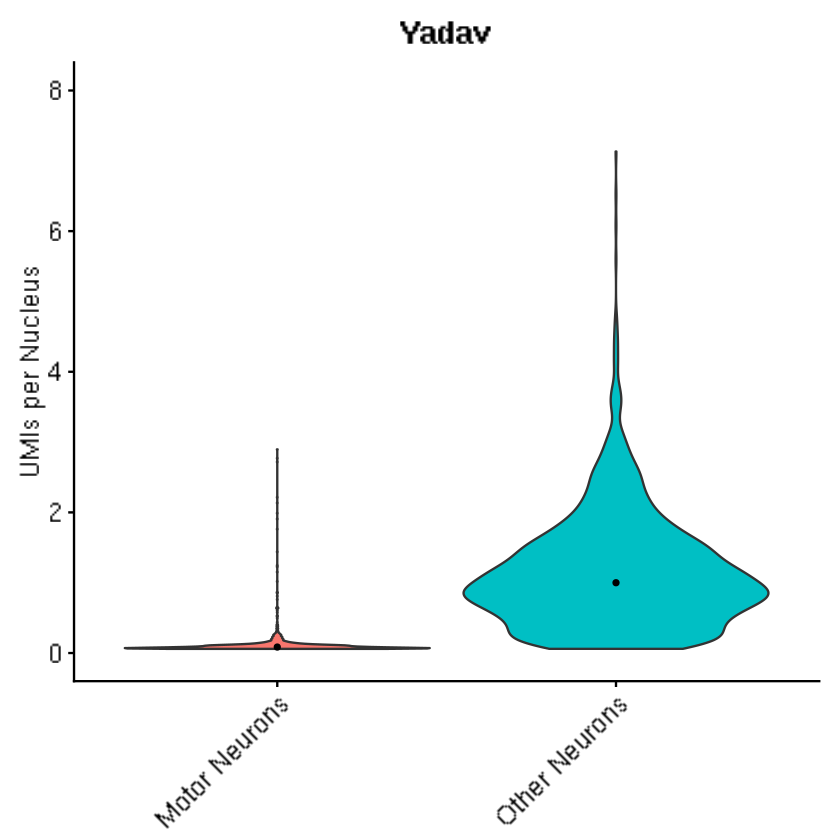

In [26]:
yadav_norm_nCount_RNA <- VlnPlot(yadav_neurons, group.by = "motor_neuron", features = "norm_nCount_RNA", pt.size = 0) + 
  labs(title = "Yadav", y = "UMIs per Nucleus") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
)  + scale_y_continuous(limits = c(0,8)) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank())

yadav_norm_nCount_RNA

In [27]:
ggsave(yadav_norm_nCount_RNA, filename = paste(fig_dir, 'yadav_norm_nCount_RNA2.svg', sep='/'), device='svg', width = 3.4, height = 3.55, units = "in")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



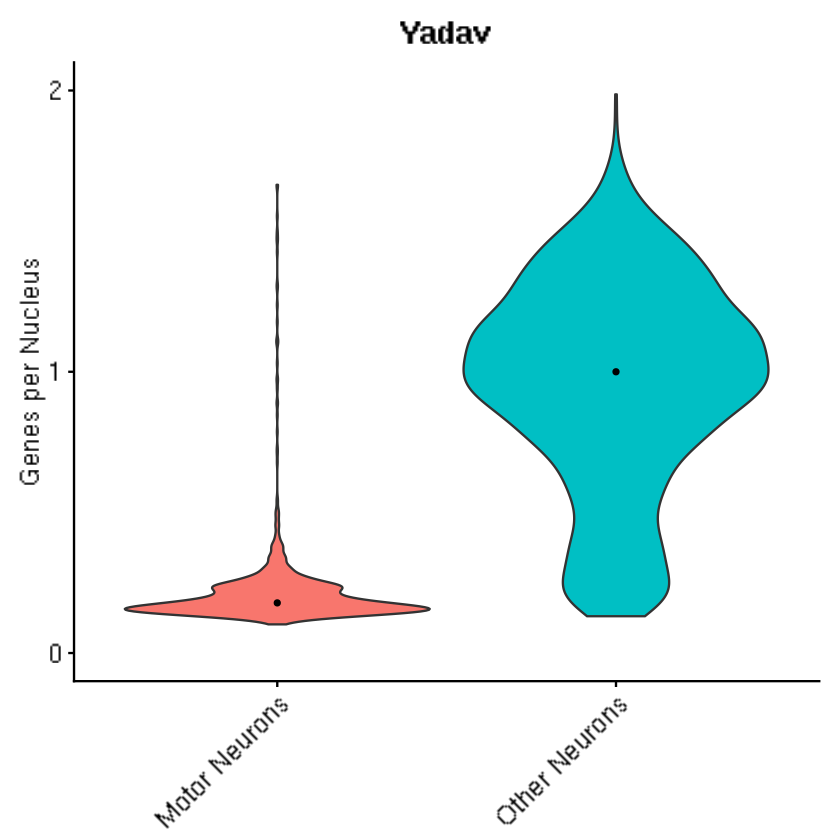

In [28]:
yadav_norm_nFeature_RNA <- VlnPlot(yadav_neurons, group.by = "motor_neuron", features = "norm_nFeature_RNA", pt.size = 0) + 
  labs(title = "Yadav", y = "Genes per Nucleus") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
) + scale_y_continuous(limits = c(0,2), breaks=c(0,1,2)) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank())
 
yadav_norm_nFeature_RNA

In [29]:
ggsave(yadav_norm_nFeature_RNA, filename = paste(fig_dir, 'yadav_norm_nFeature_RNA2.svg', sep='/'), device='svg', width = 3.4, height = 3.55, units = "in")

## Volcano plot - motoneurons vs. other neurons

In [8]:
make_volcano_plot <- function(data, labeled_pts, p_val_cutoff=0.01) {
    data <- data %>% 
    mutate(
        Expression = case_when(log2FoldChange >= 0 & padj <= p_val_cutoff ~ "Up-regulated",
                           log2FoldChange <= 0 & padj <= p_val_cutoff ~ "Down-regulated",
                           TRUE ~ "Unchanged")
    )
    
    data <- data %>% filter(gene!='hSOD1')

    
    top <- labeled_pts
    top_genes <- bind_rows(
      data %>% 
        filter(Expression == 'Up-regulated') %>% 
        arrange(padj, desc(abs(log2FoldChange))) %>% 
        head(top),
      data %>% 
        filter(Expression == 'Down-regulated') %>% 
        arrange(padj, desc(abs(log2FoldChange))) %>% 
        head(top)
    )
    
#     top_genes$Genes <- rownames(top_genes)
    
    x_scale <- max(abs(data$log2FoldChange))
    
    p1 <- ggplot(data, aes(log2FoldChange, -log(padj,10))) + # -log10 conversion  
        geom_point(aes(color = Expression), size = 4/5) +
        geom_text_repel(data = top_genes, mapping = aes(log2FoldChange, -log(padj,10), label = gene),size = 3)+
        xlim(-x_scale,x_scale)+
        xlab(expression("log"[2]*"FC")) + 
        ylab(expression("-log"[10]*"padj")) + 
        scale_color_manual(values = c("dodgerblue3", "gray50", "firebrick3")) + 
        guides(colour = guide_legend(override.aes = list(size=1.5)))  + 
        theme_classic()
p1  
}

## Save objects

In [31]:
saveRDS(yadav, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav.rds')
saveRDS(yadav_neurons, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_neurons.rds')
saveRDS(yadav_mns, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_mns.rds')

## Load Objects (saved above)

In [4]:
yadav <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav.rds')
yadav_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_neurons.rds')
yadav_mns <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_mns.rds')

## Load Blum data

In [28]:
blum <- readRDS('/oak/stanford/groups/agitler/Shared/all.exps.master.integrated.nodub.RDS')

In [29]:
blum <- subset(blum, stage == "ctl")

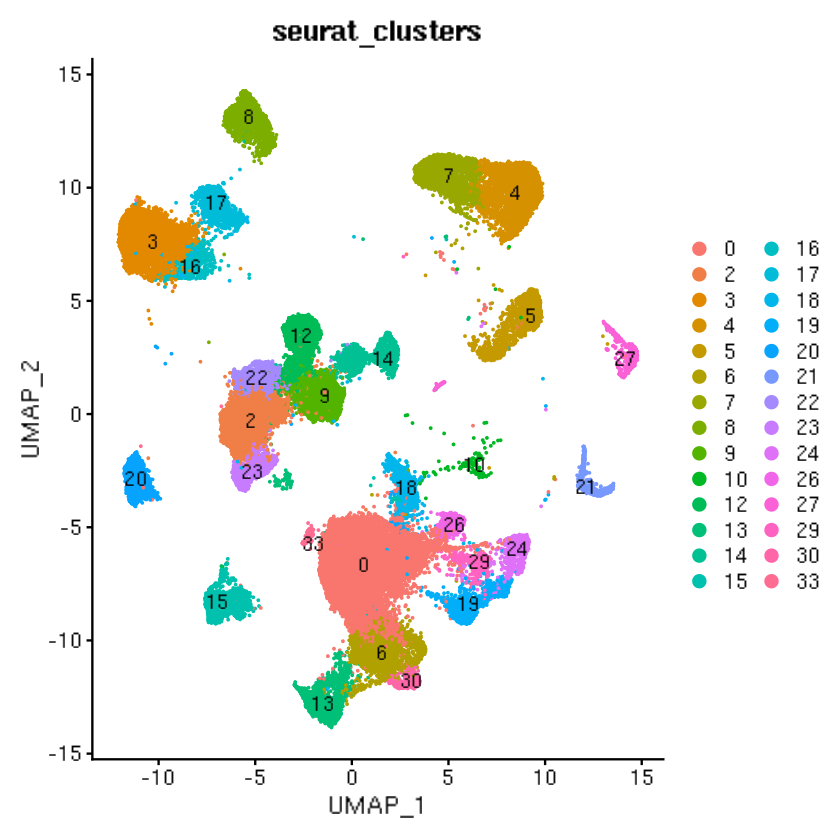

In [31]:
DimPlot(blum, reduction = "umap", group.by = "seurat_clusters", label = TRUE)

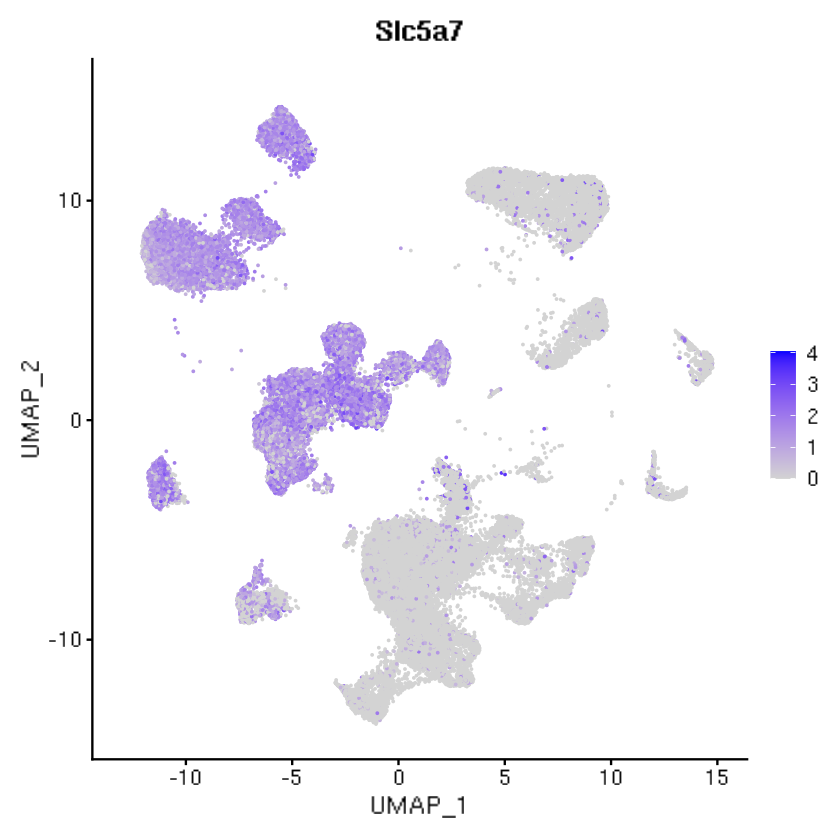

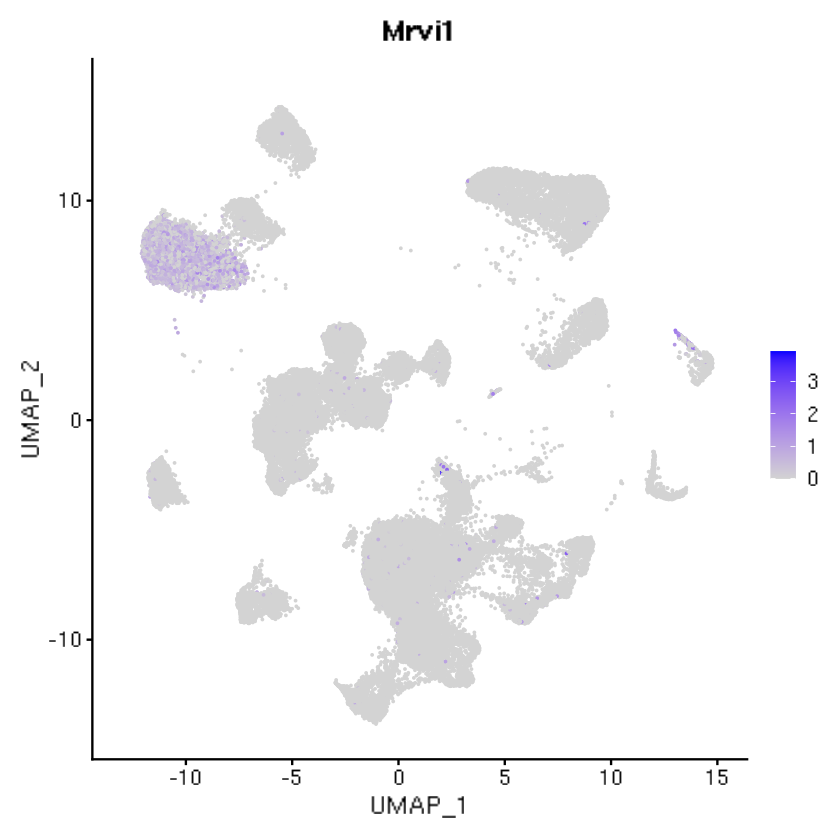

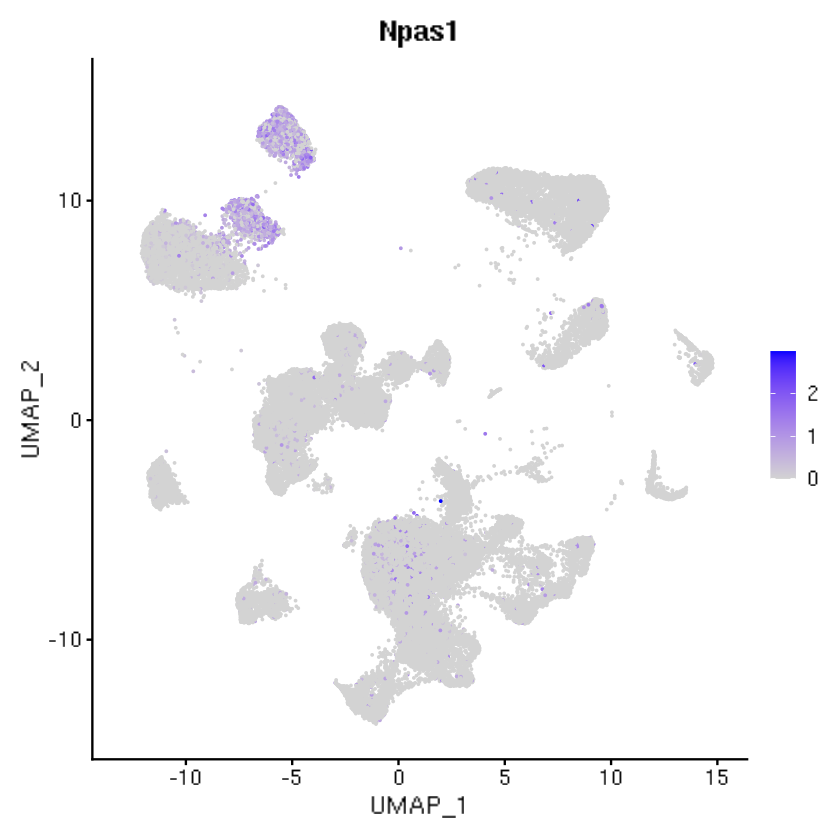

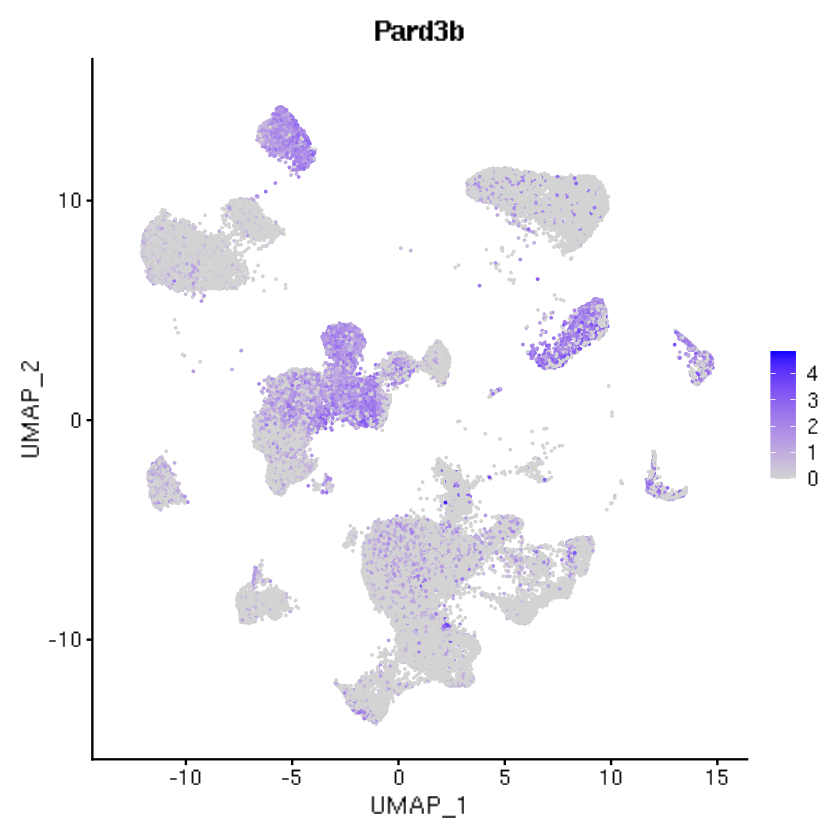

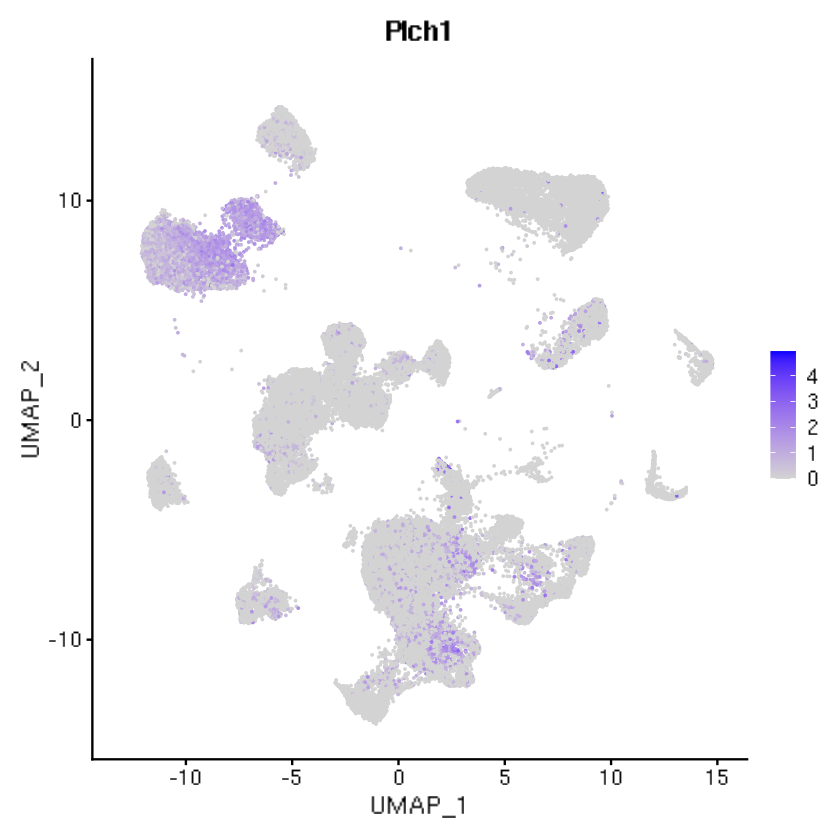

In [32]:
FeaturePlot(blum, features = c("Slc5a7"))
FeaturePlot(blum, features = c("Mrvi1"))
FeaturePlot(blum, features = c("Npas1"))
FeaturePlot(blum, features = c("Pard3b"))
FeaturePlot(blum, features = c("Plch1"))

In [ ]:
# Alpha MNs: 3, 16
# Gamma MNs: 8
# Gamma* MNs: 17

In [35]:
blum_neurons <- subset(blum, cell_type %in% c("Cholinergic neurons", "Excitatory neurons", "Inhibitory neurons"))

In [33]:
blum$skeletal_motor_neuron <- ifelse(blum$seurat_clusters %in% c("3", "16", "8", "17"), yes = "Skeletal Motor Neurons", no = "Other Cells")

In [37]:
blum_neurons$skeletal_motor_neuron <- ifelse(blum_neurons$seurat_clusters %in% c("3", "16", "8", "17"), yes = "Skeletal Motor Neurons", no = "Other Neurons")

In [38]:
blum_skeletal_mns <- subset(blum_neurons, skeletal_motor_neuron == "Skeletal Motor Neurons")

In [39]:
blum_skeletal_mns$skeletal_subtype <- "Alpha"
blum_skeletal_mns$skeletal_subtype[blum_skeletal_mns$seurat_clusters == "8"] <- "Gamma"
blum_skeletal_mns$skeletal_subtype[blum_skeletal_mns$seurat_clusters == "17"] <- "GammaStar"

## Violin plots - Blum

In [53]:
blum_neurons$skeletal_motor_neuron <- factor(blum_neurons$skeletal_motor_neuron, levels = c("Skeletal Motor Neurons", "Other Neurons"))

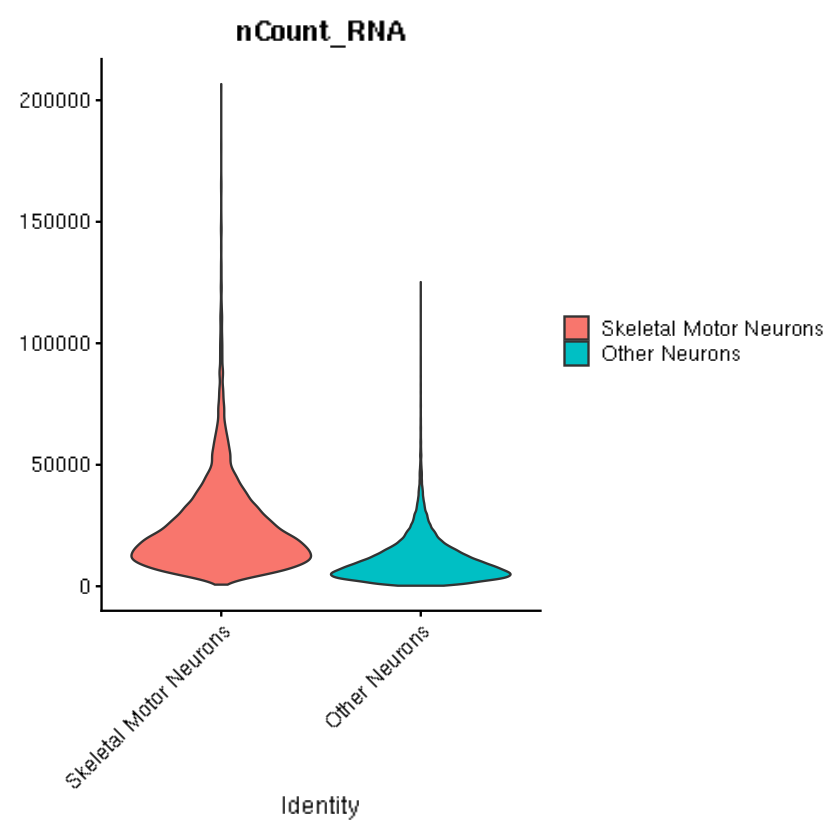

In [54]:
VlnPlot(blum_neurons, group.by = "skeletal_motor_neuron", features = "nCount_RNA", pt.size = 0)

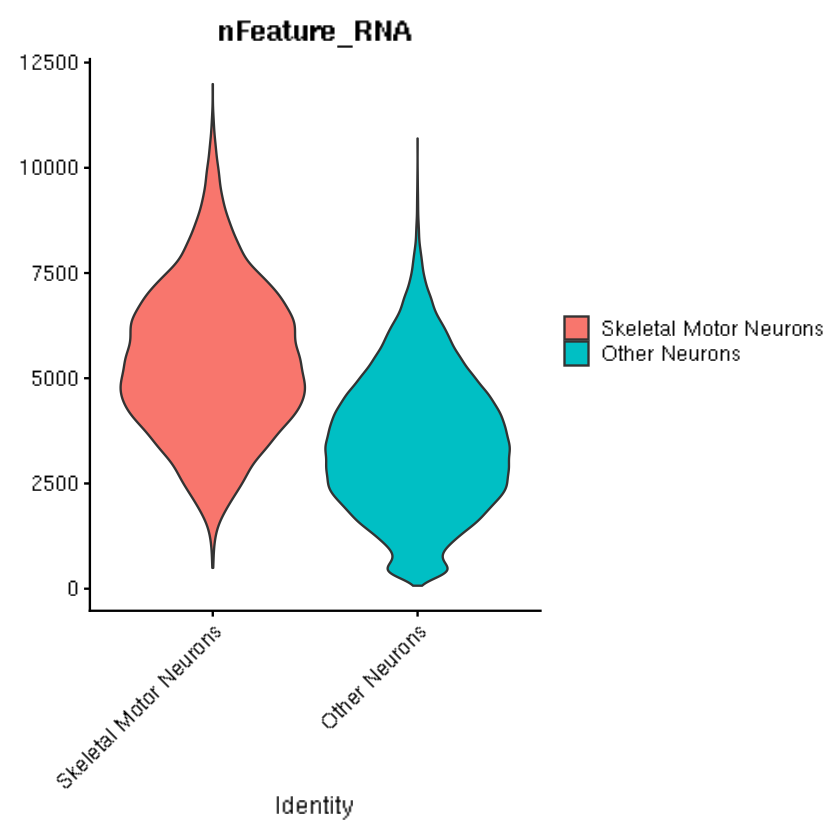

In [55]:
VlnPlot(blum_neurons, group.by = "skeletal_motor_neuron", features = "nFeature_RNA", pt.size = 0)

In [5]:
median_nCount_blum <- filter(blum_neurons@meta.data, skeletal_motor_neuron == "Other Neurons") %>% {median(.$nCount_RNA)}

In [6]:
blum_neurons$norm_nCount_RNA = blum_neurons$nCount_RNA/median_nCount_blum

In [7]:
median_nFeature_blum <- filter(blum_neurons@meta.data, skeletal_motor_neuron == "Other Neurons") %>% {median(.$nFeature_RNA)}

In [8]:
blum_neurons$norm_nFeature_RNA = blum_neurons$nFeature_RNA/median_nFeature_blum

In [9]:
median_nFeature_blum

[1] 3390

In [17]:
filter(blum_neurons@meta.data, skeletal_motor_neuron == "Skeletal Motor Neurons") %>% {median(.$nFeature_RNA)}

[1] 5333

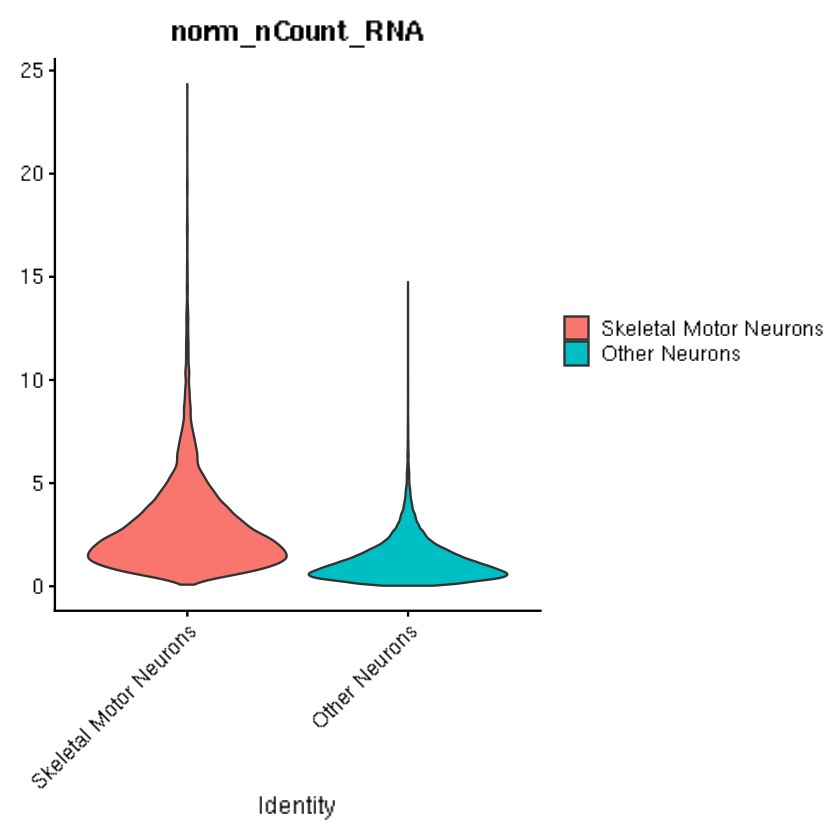

In [15]:
VlnPlot(blum_neurons, group.by = "skeletal_motor_neuron", features = "norm_nCount_RNA", pt.size = 0)

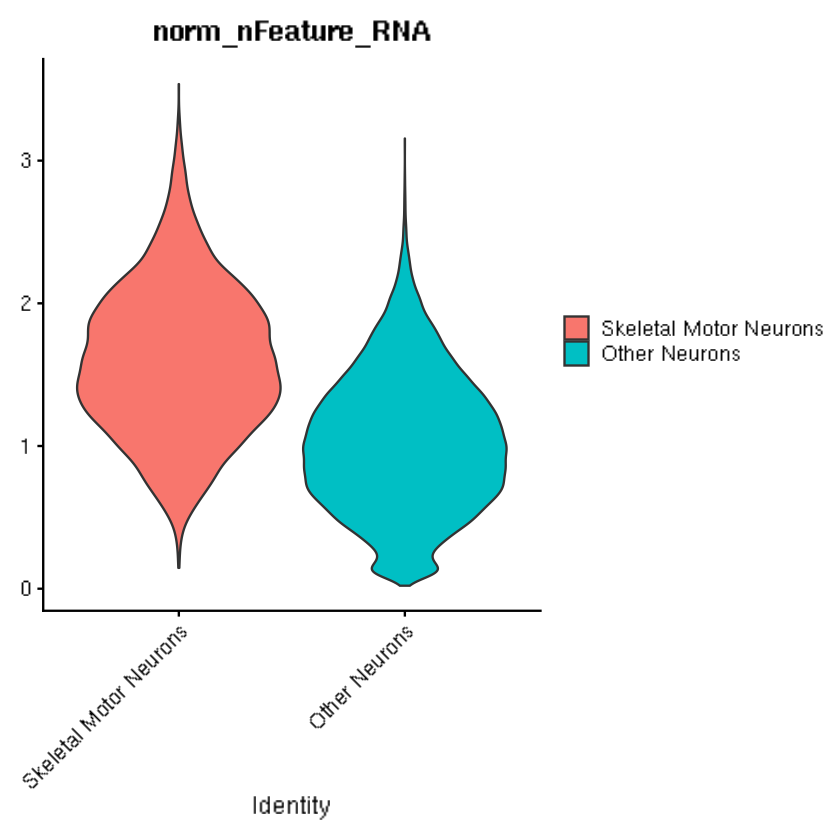

In [16]:
VlnPlot(blum_neurons, group.by = "skeletal_motor_neuron", features = "norm_nFeature_RNA", pt.size = 0)

## Save objects

In [62]:
saveRDS(blum, file = '/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/blum.rds')
saveRDS(blum_neurons, file = '/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/blum_neurons.rds')
saveRDS(blum_skeletal_mns, file = '/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/blum_mns.rds')

In [4]:
blum <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/blum.rds')
blum_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/blum_neurons.rds')
blum_skeletal_mns <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/blum_mns.rds')